In [8]:
import os
import json
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import matplotlib
import logging, coloredlogs
import collections

logger = logging.getLogger(__name__)
coloredlogs.CHROOT_FILES = []
coloredlogs.install(level=logging.INFO, use_chroot=False)

In [9]:
def rmv(dt):
    for x in dt:
        if x['time'] is None:
            x['time'] = 0.00001
    return dt        
    #return [x for x in dt if x['time'] is not None]

# Data collected by calling diag() on a real device - benchmarking
perfs = [
    {'random_scalar': 0.211/512.},
    {'encodeint_into': 4.5150/131072.},
    {'encodeint': 4.5150/131072.},
    {'decodeint_into': 7.3500/131072.},
    {'decodeint': 7.3500/131072.},
    {'decodeint_into_noreduce': 4.6370/131072.},
    {'sc_copy': 3.2540/131072.},

    {'scalarmult_base': 2.0880/256.},
    {'encodepoint_into': 144.4460/131072.},
    {'decodepoint_into': 154.7630/131072.},

    {'scalarmult_into': 370.1170/16384.},
    {'scalarmult_base_into': 127.0400/16384.},
    {'point_add_into': 2.0050/16384.},
    {'point_sub_into': 2.0730/16384.},
    {'add_keys2_into': 309.2620/16384.},
    {'add_keys3_into': 336.4210/16384.},
    {'check_ed25519point': 134.7630/131072.},

    {'sc_mul_into': 6.4250/131072.},
    {'sc_muladd_into': 7.1800/131072.},
    {'sc_mulsub_into': 7.2060/131072.},
    {'sc_sub_into': 4.1880/131072.},
    {'sc_add_into': 4.1880/131072.},
    {'sc_inv_into': 106.3400/131072.},

    {'_vector_exponent_custom': 3.192/128.},
    {'_hadamard_fold': 1.646/128.},
    {'_scalar_fold': 0.133/128.},

    {'new_point': 0.0440/256.},
    {'new_scalar': 0.0910/256.},
    {'keccak_hash_into': 63.7650/131072.},
    {'xmr_fast_hash': 63.7650/131072.},
    {'cn_fast_hash': 63.7650/131072.},
    {'hash_to_point_into': 398.0110/131072.},
    {'hash_to_scalar_into': 70.6690/131072.},
    {'gen_commitment': 309.2620/16384.},
    
]

def perfs_map(prefs):
    res = collections.OrderedDict()
    for e in prefs:
        for k in e:
            res[k] = e[k]
    return res

perfsm = perfs_map(perfs)

def add_timing(data):
    for en in data:
        k = en['key']
        if k in perfsm:
            en['time'] = en['ctr'] * perfsm[k]
            continue
        k1 = k+'_into'
        if k1 in perfsm:
            en['time'] = en['ctr'] * perfsm[k1]
            continue
        print('%s not in perfs' % k)
        en['time']=0.0001
    return data

def to_entries(data):
    return [{'key':k, 'ctr':data[k]} for k in data]

def aliask(k):
    if k.endswith('_into'):
        k = k[:-5]
    if k == 'decodeint_into_noreduce':
        return 'dec(a)'
    
    db = {
        'decodeint': 'dec(a%l)',
        'encodeint': 'enc(a)',
        'decodepoint': 'dec(P)',
        'encodepoint': 'enc(P)',
        'new_scalar': 'new a',
        'new_point': 'new P',
        'sc_add': 'a+b',
        'sc_sub': 'a-b',
        'sc_mul': 'a*b',
        'sc_muladd': 'c+ab',
        'sc_mulsub': 'c-ab',
        'sc_inv': 'a^-1',
        'sc_copy': 'a<-b',
        'add_keys2': 'aG+bB',
        'add_keys3': 'aA+bB',
        'point_add': 'A+B',
        'point_sub': 'A-B',
        'point_eq': 'A==B',
        'scalarmult_base': 'aG',
        'scalarmult': 'aP',
        'hash_to_scalar': 'Hs(x)',
        'hash_to_point': 'Hp(x)',
        'xmr_fast_hash': 'H(x)',
        'hasher': 'H(x)',
        'keccak_factory': 'H(x)',
        'gen_commitment': 'aG+bH',
        'ct_equal': 'X==Y',
        'cn_fast_hash': 'H(x)',
        'sc_check': 'check(x)',
        'check_ed25519point': 'check(P)',
        'random_bytes': 'rand()',
    }
    
    return db[k] if k in db else k

def accum_alias(data):
    res_c = collections.defaultdict(lambda: 0)
    res_t = collections.defaultdict(lambda: 0)
    for rec in data:
        k = aliask(rec['key'])
        res_c[k] += rec['ctr']
        res_t[k] += rec['time']
    return [collections.OrderedDict([('key', x), ('ctr', res_c[x]), ('time', res_t[x])]) for x in sorted(res_c.keys())]
        

In [10]:
ps16 = rmv(json.loads('[{"key": "add_keys2_into", "ctr": 18, "time": 0.339765380859375}, {"key": "add_keys3_into", "ctr": 2236, "time": 45.91292456054688}, {"key": "decodeint_into", "ctr": 6244, "time": 0.3501388549804687}, {"key": "decodeint_into_noreduce", "ctr": 27724, "time": 0.9808058776855468}, {"key": "decodepoint_into", "ctr": 6150, "time": 7.26160011291504}, {"key": "encodeint", "ctr": 75, "time": 0.0025835037231445312}, {"key": "encodeint_into", "ctr": 16766, "time": 0.5775336456298827}, {"key": "encodepoint_into", "ctr": 1806, "time": 1.990276153564453}, {"key": "hash_to_scalar_into", "ctr": 1, "time": 0.0005391616821289062}, {"key": "new_scalar", "ctr": 303, "time": 0.10770703125}, {"key": "point_add_into", "ctr": 2142, "time": 0.2621282958984375}, {"key": "prng", "ctr": 67, "time": null}, {"key": "sc_add_into", "ctr": 2178, "time": 0.06959124755859375}, {"key": "sc_copy", "ctr": 5, "time": 0.0001241302490234375}, {"key": "sc_mul_into", "ctr": 13284, "time": 0.6511665344238281}, {"key": "sc_muladd_into", "ctr": 8272, "time": 0.45313232421875}, {"key": "sc_sub_into", "ctr": 2048, "time": 0.0654375}, {"key": "scalarmult_base_into", "ctr": 2, "time": 0.0155078125}, {"key": "scalarmult_into", "ctr": 1616, "time": 36.5056806640625}, {"key": "new_point", "ctr": 17, "time": 0.002921875}, {"key": "sc_inv_into", "ctr": 107, "time": 0.08681015014648438}]'))

In [11]:
ps16 = accum_alias(ps16)

In [12]:
data_sctr = sorted(ps16, key=lambda x: -x['ctr'])
data_stime = sorted(ps16, key=lambda x: -x['time'])

In [13]:
print(sum([x['time'] for x in ps16]))

95.63638481689453


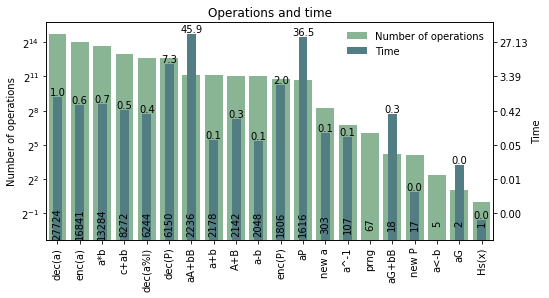

In [14]:
gdata = data_sctr
max_ctr = max([x['ctr'] for x in gdata])
max_time = max([x['time'] for x in gdata])
uniscale = (float(max_ctr) / max_time)
for ix, en in enumerate(gdata):
    data_sctr[ix]['time_sc'] = en['time'] * uniscale

df = pd.DataFrame(gdata)
colors = sns.cubehelix_palette(8, start=.5, rot=-.75)
color1 = colors[2] + [0.5]
color2 = colors[4] + [0.5]
    
fig, ax = pyplot.subplots(figsize=(8, 4))
ax.tick_params(axis='x', labelrotation=90)
    
plt0 = sns.barplot(x='key', y='ctr', data=df, color=color1, label='Number of operations')
patches0 = [x for x in plt0.patches]

plt1 = sns.barplot(x='key', y='time_sc', data=df, color=color2, label='Time')
patches1 = [x for x in plt1.patches if x not in patches0]

plt.legend(loc='best')#, framealpha=0.0, frameon=False)
plt.legend().get_frame().set_facecolor('none')
plt.legend().get_frame().set_linewidth(0.0)
plt.title("Operations and time")

#for p in plt0.patches:
#    r, g, b, a = p.get_facecolor()
#    p.set_facecolor((r, g, b, .5))
    
newwidth = 0.4
for iix, bar in enumerate(patches1):
    x, width = bar.get_x(), bar.get_width()
    centre = x + width / 2.
    bar.set_x(centre - newwidth / 2.)
    bar.set_width(newwidth)

    cx = bar.get_x()
    wi = bar.get_width()
    ct = cx + wi/2.
    ax.annotate('%.1f' % gdata[iix]['time'], (ct, bar.get_y() + bar.get_height()), 
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

for iix, bar in enumerate(patches0):
    cx = bar.get_x()
    wi = bar.get_width()
    ct = cx + wi/2.
    ax.annotate('%.0f' % gdata[iix]['ctr'], (ct, bar.get_y() + 0.2), rotation=90,
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    

ax.set_yscale("log", basey=2)
ax.set_ylabel("Number of operations")  
ax.set_ylim((0.1, max_ctr * 2))
ax.get_xaxis().set_visible(True)
ax.set_xlabel(None)
vals = ax.get_yticks()

#ax.set_yticklabels(['%.0f%%' % x for x in vals if x <= 100])

ax2 = ax.twinx()
ax2.set_yscale("log", basey=2)
ax2.set_ylim(ax.get_ylim())
tcks = [float(x) for x in (0+(ax.get_yticks()-0)/uniscale)]
ax2.set_yticklabels(['%.2f' % (x) for x in tcks])
#ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.set_ylabel('Time')

fname = './ops_time.pdf'
plt.savefig(fname, bbox_inches='tight', dpi=400)
plt.savefig(os.path.splitext(fname)[0] + '.png', bbox_inches='tight', dpi=400)

In [15]:
data_sctr

[OrderedDict([('key', 'dec(a)'),
              ('ctr', 27724),
              ('time', 0.9808058776855468),
              ('time_sc', 592.2485316110783)]),
 OrderedDict([('key', 'enc(a)'),
              ('ctr', 16841),
              ('time', 0.5801171493530273),
              ('time_sc', 350.29717672316707)]),
 OrderedDict([('key', 'a*b'),
              ('ctr', 13284),
              ('time', 0.6511665344238281),
              ('time_sc', 393.19954398808125)]),
 OrderedDict([('key', 'c+ab'),
              ('ctr', 8272),
              ('time', 0.45313232421875),
              ('time_sc', 273.6188268746387)]),
 OrderedDict([('key', 'dec(a%l)'),
              ('ctr', 6244),
              ('time', 0.3501388549804687),
              ('time_sc', 211.42738582634277)]),
 OrderedDict([('key', 'dec(P)'),
              ('ctr', 6150),
              ('time', 7.26160011291504),
              ('time_sc', 4384.835064579005)]),
 OrderedDict([('key', 'aA+bB'),
              ('ctr', 2236),
              ('

In [19]:
experiments = [
    'tsx_t_uns_xx_in02-out02-ring12.txt',
    'tsx_t_uns_xx_in02-out02-ring24.txt',
    'tsx_t_uns_xx_in02-out02-ring48.txt',
    'tsx_t_uns_xx_in16-out02-ring12.txt',
    'tsx_t_uns_xx_in32-out02-ring12.txt',
    'tsx_t_uns_xx_in64-out02-ring12.txt',
    'tsx_t_uns_xx_in128-out02-ring12.txt',
    'tsx_t_uns_xx_in02-out16-ring12.txt',
    'tsx_t_uns_xx_in16-out16-ring12.txt',
]
exp_desc_long = [
    'in002-out02-r12',
    'in002-out02-r24',
    'in002-out02-r48',
    'in016-out02-r12',
    'in032-out02-r12',
    'in064-out02-r12',
    'in128-out02-r12',
    'in002-out16-r12',
    'in016-out16-r12',
]
exp_desc = [
    '2, 2',
    '2, 2, 24',
    '2, 2, 48',
    '16, 2',
    '32, 2',
    '64, 2',
    '128, 2',
    '2, 16',
    '16, 16',
]
files = [
    'experiments/txsign/state_count/log-emu.json',
    'experiments/txsign/ops_count/log-emu.json',
    'experiments/txsign/timing/log-hw-2.json',
    'experiments/txsign/timing/log-emu-2.json',
]


In [20]:
cwdir = '/Users/dusanklinec/workspace/monero-docs-paper-data'

In [21]:
jsons = [json.load(open(os.path.join(cwdir, fname))) for fname in files]

In [22]:
times_total_emu = [x['time_total'] for x in jsons[3][:-1]]
times_total_hw = [x['time_total'] for x in jsons[2][:-1]]

times_steps_emu = [x['rtime_total_steps'] for x in jsons[3][:-1]]
times_steps_hw = [x['rtime_total_steps'] for x in jsons[2][:-1]]

ram_hw = [x['mem_max_min'] for x in jsons[2][:-1]]
state_max = [x['max_state'] for x in jsons[0][:-1]]
roundtrips = [len(x['steps'])-1 for x in jsons[0][:-1]]

fld_width = 8
cols = ['Configuration', 'Time Emu', 'Time', 'sum Steps', 'Round-trips', 'RAM', 'State min', 'State real']
cols2 = [x.rjust(max(len(y) for y in cols)) for x in cols]

rows = [
    [cols2[0], *[('%s'%x).rjust(fld_width) for x in exp_desc]],
    [cols2[1], *[('%.2f' % (x/1000000.)).rjust(fld_width) for x in times_total_emu]],
    [cols2[2], *[('%.2f' % (x/1000000.)).rjust(fld_width) for x in times_total_hw]],
    [cols2[3], *[('%.2f' % (x/1000000.)).rjust(fld_width) for x in times_steps_hw]],
    [cols2[4], *[('%d' % (x)).rjust(fld_width) for x in roundtrips]],
    [cols2[5], *[('%d' % (x)).rjust(fld_width) for x in ram_hw]],
    [cols2[6], *[('%d' % (x[0])).rjust(fld_width) for x in state_max]],
    [cols2[7], *[('%d' % (x[1])).rjust(fld_width) for x in state_max]],
]

for ix in range(len(rows)):
    print(' & '.join(rows[ix]) + '\\\\ \\hline')

Configuration &     2, 2 & 2, 2, 24 & 2, 2, 48 &    16, 2 &    32, 2 &    64, 2 &   128, 2 &    2, 16 &   16, 16\\ \hline
     Time Emu &     9.31 &     7.68 &    21.80 &    29.93 &    58.13 &   106.32 &   209.88 &    21.45 &    42.21\\ \hline
         Time &    16.90 &    21.45 &    30.82 &    83.22 &   156.82 &   306.74 &   604.09 &    46.13 &   118.42\\ \hline
    sum Steps &    12.49 &    14.63 &    19.59 &    56.30 &   106.69 &   207.33 &   408.42 &    36.62 &    81.05\\ \hline
  Round-trips &       14 &       14 &       14 &       56 &      104 &      200 &      392 &       28 &       70\\ \hline
          RAM &    41264 &    70768 &    79328 &    42176 &    42208 &    42048 &    58512 &    41376 &    42464\\ \hline
    State min &     2385 &     2385 &     2385 &     2385 &     2385 &     2385 &     2385 &     4406 &     4406\\ \hline
   State real &     5315 &     5315 &     5315 &     5315 &     5315 &     5315 &     5315 &     9224 &     9224\\ \hline


In [23]:
exp_data = jsons[1][-2]['acc_ops']
#del exp_data['random_bytes']
exp_data = to_entries(exp_data)
exp_data = add_timing(exp_data)
exp_data = accum_alias(exp_data)
data_sctr = sorted(exp_data, key=lambda x: -x['ctr'])
data_stime = sorted(exp_data, key=lambda x: -x['time'])

hasher not in perfs
keccak_factory not in perfs
point_eq not in perfs
sc_check not in perfs
ct_equal not in perfs
random_bytes not in perfs


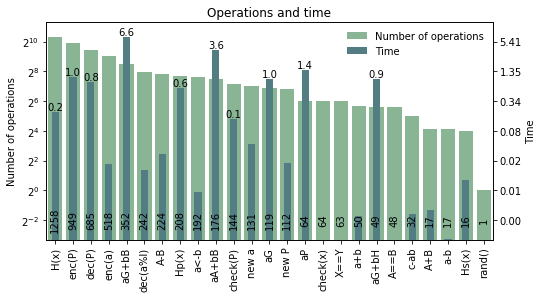

In [24]:
gdata = data_sctr
max_ctr = max([x['ctr'] for x in gdata])
max_time = max([x['time'] for x in gdata])
uniscale = (float(max_ctr) / max_time)
for ix, en in enumerate(gdata):
    data_sctr[ix]['time_sc'] = en['time'] * uniscale

df = pd.DataFrame(gdata)
colors = sns.cubehelix_palette(8, start=.5, rot=-.75)
color1 = colors[2] + [0.5]
color2 = colors[4] + [0.5]
    
fig, ax = pyplot.subplots(figsize=(8, 4))
ax.tick_params(axis='x', labelrotation=90)
    
plt0 = sns.barplot(x='key', y='ctr', data=df, color=color1, label='Number of operations')
patches0 = [x for x in plt0.patches]

plt1 = sns.barplot(x='key', y='time_sc', data=df, color=color2, label='Time')
patches1 = [x for x in plt1.patches if x not in patches0]

plt.legend(loc='best')#, framealpha=0.0, frameon=False)
plt.legend().get_frame().set_facecolor('none')
plt.legend().get_frame().set_linewidth(0.0)
plt.title("Operations and time")

#for p in plt0.patches:
#    r, g, b, a = p.get_facecolor()
#    p.set_facecolor((r, g, b, .5))
    
newwidth = 0.4
for iix, bar in enumerate(patches1):
    x, width = bar.get_x(), bar.get_width()
    centre = x + width / 2.
    bar.set_x(centre - newwidth / 2.)
    bar.set_width(newwidth)

    cx = bar.get_x()
    wi = bar.get_width()
    ct = cx + wi/2.
    if gdata[iix]['time'] <= 0.1:
        continue
    ax.annotate('%.1f' % gdata[iix]['time'], (ct, bar.get_y() + bar.get_height()), 
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

for iix, bar in enumerate(patches0):
    cx = bar.get_x()
    wi = bar.get_width()
    ct = cx + wi/2.
    ax.annotate('%.0f' % gdata[iix]['ctr'], (ct, bar.get_y() + 0.2), rotation=90,
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    

ax.set_yscale("log", basey=2)
ax.set_ylabel("Number of operations")  
ax.set_ylim((0.1, max_ctr * 2))
ax.get_xaxis().set_visible(True)
ax.set_xlabel(None)
vals = ax.get_yticks()

#ax.set_yticklabels(['%.0f%%' % x for x in vals if x <= 100])

ax2 = ax.twinx()
ax2.set_yscale("log", basey=2)
ax2.set_ylim(ax.get_ylim())
tcks = [float(x) for x in (0+(ax.get_yticks()-0)/uniscale)]
ax2.set_yticklabels(['%.2f' % (x) for x in tcks])
#ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.set_ylabel('Time')

fname = './ops_time_tx.pdf'
plt.savefig(fname, bbox_inches='tight', dpi=400)
plt.savefig(os.path.splitext(fname)[0] + '.png', bbox_inches='tight', dpi=400)

In [173]:
exp_data = jsons[2][-2]
mem_min = exp_data['mem_min']
steps = exp_data['steps']

In [177]:
gdata = []
for ix, st in enumerate(steps[:-1]):
    gdata.append({'ix':ix, 'step':st['step'], 'mem': max(st['mems']) - mem_min, 'time': (st['rtime'] if st['rtime'] else st['time'])/1000000.})
    
# steps post-processing to match paper notation
step_fix = {4:3, 5:3, 6:4, 7:5, 8:5, 9:5, 10:5}
for ix, dt in enumerate(reversed(gdata)):
    if dt['step'] in step_fix: dt['step'] = step_fix[dt['step']]
        
# all-mems
gdatam = []
for ix, st in enumerate(steps[:-1]):
    for ix2, cm in enumerate(st['mems']):
        gdatam.append({'ix':ix + ix2/float(len(st['mems'])), 'step':st['step'], 'mem': cm - mem_min})

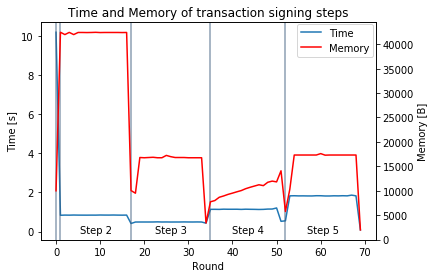

In [181]:
fig, ax = pyplot.subplots() # figsize=(8, 4)
df = pd.DataFrame(gdata)
df = df.rename(columns={'mem':'Memory', 'time': 'Time', 'ix': 'Round'})
df2 = pd.DataFrame(gdatam)
df2 = df2.rename(columns={'mem':'Memory', 'ix': 'Round'})
colors = sns.cubehelix_palette(8, start=.5, rot=-.75)

ax = sns.lineplot(x="Round", y="Time", data=df, label='Time', legend=None)
patches0 = [x for x in ax.patches]

ax2 = ax.twinx()  # lineplot
ax3 = sns.lineplot(x="Round", y="Memory", data=df, ax=ax2, color='r', label='Memory', legend=None)

ax.set_ylabel("Time [s]")  
ax2.set_ylabel("Memory [B]")  

leg = ax3.figure.legend(loc='upper right', bbox_to_anchor=(+0.875, +0.9))
plt.title("Time and Memory of transaction signing steps")

for ix, dt in enumerate(gdata):
    step = dt['step']
    add_line = ix <= 1 or gdata[ix-1]['step'] != dt['step']
    if not add_line: continue
        
    ax.axvline(dt['ix'], alpha=0.6, color=colors[5])
    if step <= 1: continue
        
    next_step_ix = [x['ix'] for x in list(gdata[ix:]) if x['step'] == step+1]
    next_step_ix = min(next_step_ix) if next_step_ix else gdata[-1]['ix']
    if next_step_ix is None: continue
    # print('Step', step, 'ix', dt['ix'], 'next ix', next_step_ix)
        
    placem = dt['ix'] + (next_step_ix - dt['ix'])/2
    ax.annotate('Step %s' % step, (placem, 0.05),
                ha='center', va='center', xytext=(0, 0), textcoords='offset points')

fname = './tsx_time_mem.pdf'
#plt.savefig(fname, bbox_inches='tight', dpi=400)
#plt.savefig(os.path.splitext(fname)[0] + '.png', bbox_inches='tight', dpi=400)
plt.show()